# Quickstart

## `Atoms` Data

`Atoms` is the primary data structure for atomistic modeling in `NFFLr`.
This represents an atomistic system in the same way as [spglib](https://spglib.readthedocs.io/en/latest/python-spglib.html#crystal-structure-cell):

- a $3 \times 3$ `lattice` matrix
- an $N \times 3$ fractional coordinates array `positions`
- an array of `N` atomic `numbers`

These variables are stored as PyTorch tensors to facilitate auto-batching, flexible conversion to graph deep learning formats, and automatic differentiation.

In [2]:
import torch
import nfflr

cell = 4.1 * torch.eye(3)
positions = torch.tensor([[0,0,0], [0.5, 0.5, 0.5]])
numbers = torch.tensor([24, 22])
atoms = nfflr.Atoms(cell, positions, numbers)
atoms

Atoms(cell=tensor([[4.1000, 0.0000, 0.0000],
        [0.0000, 4.1000, 0.0000],
        [0.0000, 0.0000, 4.1000]]), positions=tensor([[0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.5000]]), numbers=tensor([24, 22]), _batch_num_atoms=None)

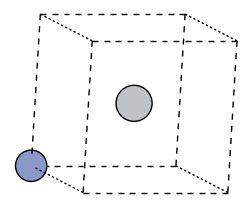

In [3]:
from ase import Atoms as AseAtoms
from ase.visualize.plot import plot_atoms

import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(3,3))
ase_atoms = AseAtoms(scaled_positions=positions, numbers=numbers, cell=cell)
plot_atoms(ase_atoms, ax, radii=0.3, rotation=("10x,20y,0z"), show_unit_cell=2)
ax.axis("off");

## Models
### Common model interface

`NFFLr` models are PyTorch modules for modeling properties of atomistic systems.

Different modeling approaches use a variety of input representations;
`NFFLr` aims to simplify exploratory research by providing a common modeling interface, where all models internally transform `Atoms` inputs to their native input representation, *e.g.* the [DGLGraph](https://docs.dgl.ai/api/python/dgl.DGLGraph.html) structure expected by `ALIGNN`.

In [4]:
cfg = nfflr.models.ALIGNNConfig(alignn_layers=2, gcn_layers=2)
alignn_model = nfflr.models.ALIGNN(cfg)
with torch.no_grad():
    print(alignn_model(atoms))

Setting it to max atomic number available here, 103
Setting it to max atomic number available here, 103
Setting it to max atomic number available here, 103
tensor(0.4806)


/Users/bld/.pyenv/versions/3.10.9/envs/nfflr/lib/python3.10/site-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


`NFFLr` also transparently converts inputs from common atomistic modeling libraries, such as jarvis and ase.
This is an experimental feature that is currently implemented with the [plum multiple dispatch library](https://github.com/beartype/plum#plum-multiple-dispatch-in-python).
For example, calling `alignn_model` on an `ase.Atoms` structure automatically converts the data to `nfflr.Atoms` and then to the `ALIGNN` `DGLGraph` format:

In [5]:
with torch.no_grad():
    print(alignn_model(ase_atoms))

convert
tensor(0.4806)


### Force field models

Enabling the `compute_forces` model configuration field will cause the model to compute both a scalar property prediction
and its (negative) gradient with respect to the (cartesian) atomic coordinates - *i.e.* the force components on each atom.

In [6]:
cfg = nfflr.models.ALIGNNConfig(
    alignn_layers=2, 
    gcn_layers=2, 
    compute_forces=True
)
alignn_model = nfflr.models.ALIGNN(cfg)
alignn_model(atoms)

/Users/bld/.pyenv/versions/3.10.9/envs/nfflr/lib/python3.10/site-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


{'total_energy': tensor(-0.0822, grad_fn=<SqueezeBackward0>),
 'forces': tensor([[-2.9802e-06, -1.2040e-05,  1.7881e-07],
         [ 6.3032e-06,  9.8795e-06,  7.4506e-08]], grad_fn=<MulBackward0>),
 'stress': tensor([[[ 3.8823e+01,  6.1393e-06, -4.8280e-06],
          [ 6.3181e-06,  3.8823e+01,  3.4571e-06],
          [-5.0068e-06,  4.1127e-06,  3.8823e+01]]],
        grad_fn=<SegmentReduceBackward>)}

### input representations
`NFFLr` also allows to directly provide inputs to models in the native input representation expected by the model.
This facilitates efficient precomputation and caching during training.
For example, `ALIGNN` requires `DGLGraph` inputs with node features `atomic_number` and edge features `r` (the bond vectors pointing from atoms to their neighbors).

In [8]:
from nfflr.data.graph import periodic_radius_graph
g = periodic_radius_graph(atoms, r=6)
g

Graph(num_nodes=2, num_edges=52,
      ndata_schemes={'Xfrac': Scheme(shape=(3,), dtype=torch.float32), 'coord': Scheme(shape=(3,), dtype=torch.float32), 'atomic_number': Scheme(shape=(), dtype=torch.int32)}
      edata_schemes={'r': Scheme(shape=(3,), dtype=torch.float32)})

In [9]:
alignn_model(g)

/Users/bld/.pyenv/versions/3.10.9/envs/nfflr/lib/python3.10/site-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


{'total_energy': tensor(-0.1124, grad_fn=<SqueezeBackward0>),
 'forces': tensor([[ 3.1292e-06, -9.0003e-06,  5.1253e-06],
         [-3.0398e-06,  8.8811e-06, -5.0673e-06]], grad_fn=<MulBackward0>),
 'stress': tensor([[[-1.0395e+01,  2.8610e-06,  2.6226e-06],
          [ 2.8610e-06, -1.0395e+01, -1.1325e-06],
          [ 2.6226e-06, -1.1325e-06, -1.0395e+01]]],
        grad_fn=<SegmentReduceBackward>)}

## Training utilities
### `AtomsDataset`
NFFLr makes it easy to load data and transform it into various formats.

The primary ways of interacting with data are `Atoms` and `AtomsDataset`,
which is a [PyTorch DataSet](https://pytorch.org/docs/stable/data.html) that returns `Atoms` instances.
The most convenient way to get started is with a [named Jarvis dataset](https://jarvis-tools.readthedocs.io/en/master/databases.html):

In [10]:
dataset = nfflr.AtomsDataset("dft_3d", target="formation_energy_peratom")

dataset_name='dft_3d'
Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.


The dataset yields a tuple of an `Atoms` instance and the target value, *e.g.,* `target="formation_energy_peratom"`:

In [12]:
atoms, target = dataset[0]
print(f"{atoms.cell=}")
print(f"{atoms.positions=}")
print(f"{atoms.numbers=}")
print(f"{target=}")

atoms.cell=tensor([[3.5669, 0.0000, -0.0000],
        [0.0000, 3.5669, -0.0000],
        [-0.0000, -0.0000, 9.3971]])
atoms.positions=tensor([[0.7500, 0.7500, 0.7849],
        [0.2500, 0.2500, 0.2151],
        [0.2500, 0.7500, 0.5000],
        [0.7500, 0.2500, 0.5000],
        [0.2500, 0.7500, 0.0000],
        [0.7500, 0.2500, 0.0000],
        [0.7500, 0.7500, 0.3075],
        [0.2500, 0.2500, 0.6925]])
atoms.numbers=tensor([22, 22, 29, 29, 14, 14, 33, 33], dtype=torch.int32)
target=tensor(-0.4276)


Internally, `AtomsDataset` uses a [pandas dataframe](https://pandas.pydata.org/docs/user_guide/dsintro.html#dataframe) to store the datasets, so any key in the jarvis dataset is a valid `target`.
For example, `dft_3d` contains a large number of target properties, including some non-scalar quantities:

In [13]:
selected_cols = ("jid", "formula", "formation_energy_peratom", "optb88vdw_bandgap", "elastic_tensor")
dataset.df.loc[:,selected_cols].head()

,jid,formula,formation_energy_peratom,optb88vdw_bandgap,elastic_tensor
0,JVASP-90856,TiCuSiAs,-0.42762,0.000,na
1,JVASP-86097,DyB6,-0.41596,0.000,na
2,JVASP-64906,Be2OsRu,0.04847,0.000,na
3,JVASP-98225,KBi,-0.44140,0.472,na
4,JVASP-10,VSe2,-0.71026,0.000,"[[136.4, 27.8, 17.5, 0.0, -5.5, 0.0], [27.8, 1..."


We can change the target column, but missing values currently need to be handled manually.

In [14]:
dataset.target = "elastic_tensor"
atoms, elastic_tensor = dataset[4]
elastic_tensor

tensor([[136.4000,  27.8000,  17.5000,   0.0000,  -5.5000,   0.0000],
        [ 27.8000, 136.4000,  17.5000,   0.0000,   5.5000,   0.0000],
        [ 17.5000,  17.5000,  40.7000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,  54.3000,   0.0000,  -5.5000],
        [ -5.5000,   5.5000,   0.0000,   0.0000,  13.7000,   0.0000],
        [  0.0000,   0.0000,   0.0000,  -5.5000,   0.0000,  13.7000]])

## Force field datasets

Force field datasets like `mlearn`, `alignn_ff_db`, and `m3gnet` have a special target key `target="energy_and_forces"` that configure `AtomsDataset` to return a dictionary of target values containing the total energy of the atomic configuration, the forces, and the stresses if they are available.

In [16]:
dataset = nfflr.AtomsDataset("mlearn", target="energy_and_forces")
atoms, target = dataset[0]
target

dataset_name='mlearn'
Obtaining mlearn dataset 1730...
Reference:https://github.com/materialsvirtuallab/mlearn
Loading the zipfile...
Loading completed.


{'energy': tensor(-64656.0625),
 'forces': tensor([[-1.9282e-01, -1.8793e+00, -6.6374e-01],
         [-8.2543e-03, -2.0313e-01,  3.6808e-01],
         [-5.5372e-01, -1.4736e+00,  1.2997e+00],
         [ 4.5678e-01,  5.1175e-01, -1.0934e+00],
         [-1.6499e+00, -1.6259e+00,  4.5255e-01],
         [-1.6698e-01,  6.8080e-01,  6.7749e-01],
         [ 3.6802e-02, -3.1423e+00, -2.0166e+00],
         [-1.0730e-01, -3.5780e-01,  1.1357e+00],
         [-1.9132e-01,  5.1381e-01,  3.4296e-01],
         [ 2.0090e+00,  1.5143e+00, -3.5578e-01],
         [-1.7128e-01, -2.7808e+00, -1.4215e+00],
         [-9.3987e-01, -1.6757e-02,  7.9322e-01],
         [ 3.7190e-01, -9.0627e-01, -5.2933e-01],
         [ 5.6458e-01, -9.6833e-01, -7.0043e-01],
         [-4.5756e-01, -6.5868e-02, -3.7038e-01],
         [-1.2044e+00,  6.3979e-01,  7.5036e-01],
         [-1.5743e+00,  6.4479e-02, -6.7272e-01],
         [-9.8223e-01, -9.5903e-02, -8.7198e-01],
         [ 4.9518e-01, -2.7982e-01, -4.6208e-01],
        